In [1]:
#import all packages
import numpy as np
import pandas as pd
import math
from scipy.stats import norm, skewnorm, cauchy, lognorm
import logging
import json
import sys
import os

import xlwt
import xlsxwriter
from tempfile import TemporaryFile

import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

#set color grid
clr_palette = ([sns.color_palette("YlGn", 15)[10],sns.cubehelix_palette(8)[6]])

#locate most updated PyRICE folder
pydice_folder = os.path.dirname(os.getcwd()) + '\\1_Model'
sys.path.append(pydice_folder)

from PyRICE_V9 import PyRICE

In [2]:
#Import data of RICE2010 for plotting purposes
RICE_DATA = pd.read_excel("RICE_2010_opt_000.xlsm", sheet_name="Data")
RICE_PARAMETER = pd.read_excel("RICE_2010_opt_000.xlsm", sheet_name="Parameters")
RICE_DAMAGE = pd.read_excel("RICE_2010_base_000.xlsm", sheet_name="Damage")
RICE_POP_gr = pd.read_excel("RICE_2010_base_000.xlsm", sheet_name="Pop_gr")
RICE_results = pd.read_excel("RICE_2010_opt_000.xlsm", sheet_name="Results")

regions_list = ["US", "OECD-Europe","Japan","Russia","Non-Russia Eurasia","China","India","Middle East","Africa",
                "Latin America","OHI","Other non-OECD Asia"]

In [3]:
#get dataframe format to support plotting of results
RICE_POP_gr = pd.read_excel("RICE_2010_base_000.xlsm", sheet_name="Pop_gr")

regions_list = ["US", "OECD-Europe","Japan","Russia","Non-Russia Eurasia","China","India","Middle East","Africa",
    "Latin America","OHI","Other non-OECD Asia"]

"""
####################### Population PARAMETERS and set up dataframe format #######################
"""
#get population growth rates for each region
a=[]
for i in range(31):  
    if i == 0:
        a.append("region")
    k = 2005 + 10 * i
    k = str(k)
    a.append(k)    

region_pop_gr = RICE_POP_gr.iloc[10:22,3:35]
region_pop_gr.columns =  a
region_pop_gr = region_pop_gr.set_index('region') 

In [4]:
#Run PyRICE with deterministic control variables
model = PyRICE(steps = 31, model_specification="Validation_2",fdamage =2, welfare_function="utilitarian")
results_slr = model(sr = 0.270, periodfullpart=7,miu_period=13,irstp = 0.015)

In [5]:
#Get results from RICE2010 optimal run
validation_series = pd.read_excel("RICE_2010_opt_000.xlsm", sheet_name="Validation series")

sr_opt_series = validation_series.iloc[21:33,3:34]
sr_opt_series.index = region_pop_gr.index
sr_opt_series.columns = region_pop_gr.columns

miu_opt_series = validation_series.iloc[6:18,3:34]
miu_opt_series.index = region_pop_gr.index
miu_opt_series.columns = region_pop_gr.columns

utility = validation_series.iloc[48:49,3:34]
utility.columns = region_pop_gr.columns

damages = validation_series.iloc[51:52,3:34]
damages.columns = region_pop_gr.columns

temperature = validation_series.iloc[54:55,3:34]
temperature.columns = region_pop_gr.columns

emissions = validation_series.iloc[57:58,3:34]
emissions.columns = region_pop_gr.columns

total_output = validation_series.iloc[60:61,3:34]
total_output.columns = region_pop_gr.columns

In [6]:
#output PyRICE
output_Y = model.Y
output_E = model.E
output_U = model.per_util_ww
output_D = model.damages
output_T = model.temp_atm

output_Y = pd.DataFrame(data=output_Y,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_Y = output_Y.transpose()
output_Y.loc[:,'Global PyRICE'] = output_Y.sum(axis=1)

output_E = pd.DataFrame(data=output_E,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_E = output_E.transpose()
output_E.loc[:,'Global PyRICE'] = output_E.sum(axis=1)

output_U = pd.DataFrame(data=output_U,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_U = output_U.transpose()
output_U.loc[:,'Global PyRICE'] = output_U.sum(axis=1)

output_D = pd.DataFrame(data=output_D,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_D = output_D.transpose()
output_D.loc[:,'Global PyRICE'] = output_D.sum(axis=1)

output_T = pd.DataFrame(data=output_T)
output_T.columns = ["Global PyRICE"]
output_T.index = output_D.index

output_U['Global RICE'] = utility.transpose()
output_Y['Global RICE'] = total_output.transpose()
output_E['Global RICE'] = emissions.transpose()
output_D['Global RICE'] = damages.transpose()
output_T['Global RICE'] = temperature.transpose()

output_T = output_T[['Global RICE','Global PyRICE']]
output_Y = output_Y[['Global RICE','Global PyRICE']]
output_E = output_E[['Global RICE','Global PyRICE']]
output_D = output_D[['Global RICE','Global PyRICE']]
output_U = output_U[['Global RICE','Global PyRICE']]

output_PyRICE = [output_Y,output_E,output_U,output_D,output_T]
plot_df = pd.concat(output_PyRICE, axis=1)

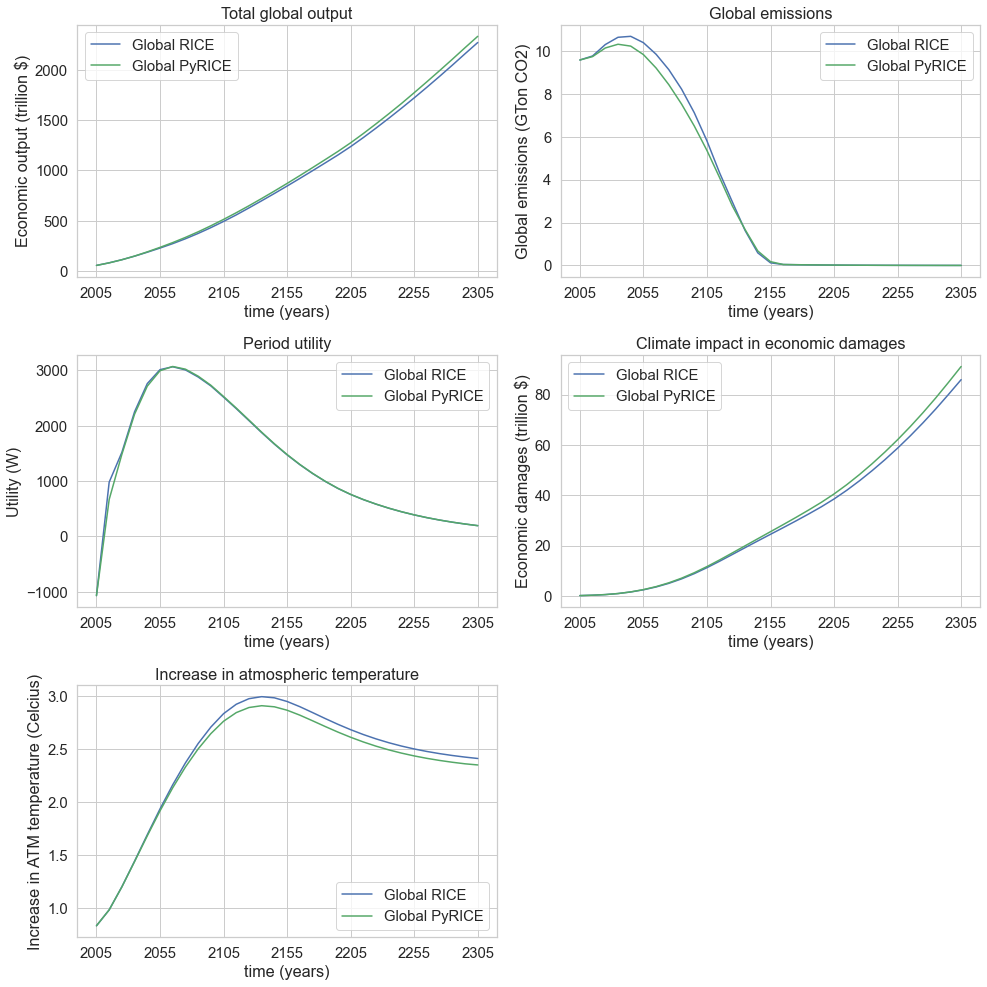

In [7]:
#set up graph with subplots to compare with original RICE output
sns.set(font_scale=1.35)  # crazy big
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14),tight_layout=True)
fig.delaxes(axes[2][1])

#fig.suptitle("Comparison of model outputs using original input for levers", fontsize=14)
plot_df.iloc[:,0].plot(ax=axes[0,0]); axes[0,0].set_title('Total global output'),axes[0,0].legend()
axes[0,0].set(xlabel='time (years)', ylabel='Economic output (trillion $)')
plot_df.iloc[:,1].plot(ax=axes[0,0],secondary_y=False, style='g'); axes[0,0].legend()


plot_df.iloc[:,2].plot(ax=axes[0,1]); axes[0,1].set_title('Global emissions'),axes[0,1].legend()
axes[0,1].set(xlabel='time (years)', ylabel='Global emissions (GTon CO2)')
plot_df.iloc[:,3].plot(ax=axes[0,1],secondary_y=False, style='g');axes[0,1].legend()


plot_df.iloc[:,4].plot(ax=axes[1,0]); axes[1,0].set_title('Period utility'),axes[1,0].legend()
axes[1,0].set(xlabel='time (years)', ylabel='Utility (W)')
plot_df.iloc[:,5].plot(ax=axes[1,0],secondary_y=False, style='g');axes[1,0].legend()


plot_df.iloc[:,6].plot(ax=axes[1,1]); axes[1,1].set_title('Climate impact in economic damages'), axes[1,1].legend()
axes[1,1].set(xlabel='time (years)', ylabel='Economic damages (trillion $)')
plot_df.iloc[:,7].plot(ax=axes[1,1],secondary_y=False, style='g'); axes[1,1].legend()

plot_df.iloc[:,8].plot(ax=axes[2,0]); axes[2,0].set_title('Increase in atmospheric temperature'), axes[2,0].legend()
axes[2,0].set(xlabel='time (years)', ylabel='Increase in ATM temperature (Celcius)')
plot_df.iloc[:,9].plot(ax=axes[2,0],secondary_y=False, style='g'); axes[2,0].legend()

plt.legend()

plt.savefig("validation_output_deterministic.png", dpi=200)



In [10]:
#get control output for plotting
output_sr = model.S[:,0:31]
output_sr = pd.DataFrame(data=output_sr,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_sr = output_sr.transpose()

output_miu = model.miu[:,0:31]
output_miu = pd.DataFrame(data=output_miu,index =region_pop_gr.index ,columns = region_pop_gr.columns)
output_miu = output_miu.transpose()

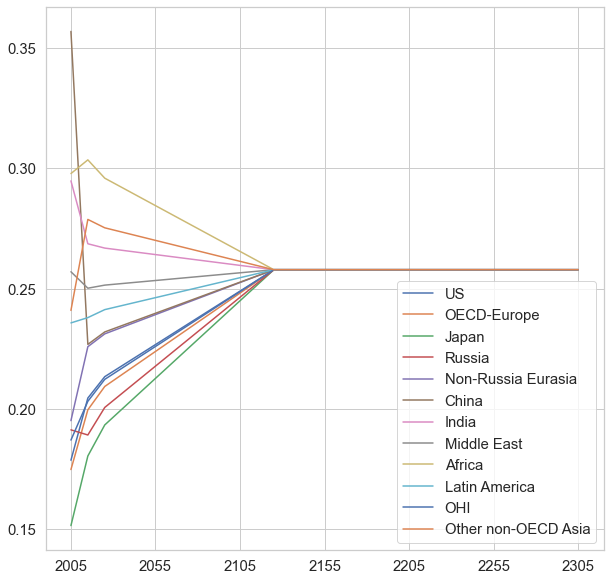

In [11]:
#plot savings rate used within the model 
output_sr.plot(subplots=False, figsize=(10, 10)); plt.legend(loc='best')

In [12]:
miu_opt_series = validation_series.iloc[6:18,3:34]
miu_opt_series.columns = region_pop_gr.columns
miu_opt_series.index = region_pop_gr.index
miu_opt_series = miu_opt_series.transpose()     
    
sr_opt_series = validation_series.iloc[21:33,3:34]
sr_opt_series.index = region_pop_gr.index
sr_opt_series.columns = region_pop_gr.columns
sr_opt_series = sr_opt_series.transpose() 

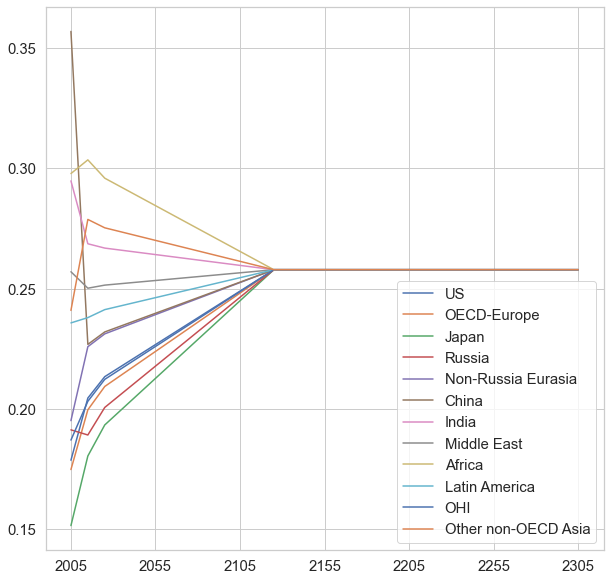

In [13]:
sns.set_style("whitegrid")

output_sr.plot(subplots=False, figsize=(10, 10)); plt.legend(loc='best')

In [14]:
yearly_output = model.CPC_post_damage[2005][:,8]
yearly_output

array([0.38991854, 0.63318507, 0.87989424, 1.25423364, 2.79773438])

In [15]:
outputCPC = model.CPC[:,0:31]
outputCPC = pd.DataFrame(data=outputCPC,index =region_pop_gr.index ,columns = region_pop_gr.columns)
outputCPC = outputCPC.transpose()

In [16]:
quintile = ["bottom 20%","second quintile","third quintile","fourth quintile","top 20%"]

In [17]:
CPC_quint_us= np.zeros((5,31))

for i  in range(0,31):
    year = 2005 + 10 * i
    yearly_output = model.CPC_post_damage[year][:,0]
    
    CPC_quint_us[:,i] = yearly_output
    
CPC_quint_us = pd.DataFrame(data=CPC_quint_us,index = quintile,columns = region_pop_gr.columns)
CPC_quint_us = CPC_quint_us.transpose()
CPC_quint_us['Average CPC RICE'] = model.CPC[0,0:31]
CPC_quint_us = CPC_quint_us * 1000


In [18]:
CPC_quint_africa= np.zeros((5,31))

for i  in range(0,31):
    year = 2005 + 10 * i
    yearly_output = model.CPC_post_damage[year][:,8]
    
    CPC_quint_africa[:,i] = yearly_output
    
CPC_quint_africa = pd.DataFrame(data=CPC_quint_africa,index = quintile,columns = region_pop_gr.columns)
CPC_quint_africa = CPC_quint_africa.transpose()
CPC_quint_africa['Average CPC RICE'] = model.CPC[8,0:31]
CPC_quint_africa = CPC_quint_africa * 1000

In [19]:
CPC_post_damage_lowest = np.zeros((12,31))

for i  in range(0,31):
    year = 2005 + 10 * i
    yearly_output = model.CPC_post_damage[year][0]
    
    CPC_post_damage_lowest[:,i] = yearly_output
    
CPC_post_damage_lowest = pd.DataFrame(data=CPC_post_damage_lowest,index =region_pop_gr.index ,columns = region_pop_gr.columns)
CPC_post_damage_lowest = CPC_post_damage_lowest.transpose()

In [20]:
CPC_pre_damage_lowest = np.zeros((12,31))

for i  in range(0,31):
    year = 2005 + 10 * i
    yearly_output = model.CPC_pre_damage[year][0]
    
    CPC_pre_damage_lowest[:,i] = yearly_output
    
CPC_pre_damage_lowest = pd.DataFrame(data=CPC_pre_damage_lowest,index =region_pop_gr.index ,columns = region_pop_gr.columns)


CPC_pre_damage_lowest = CPC_pre_damage_lowest.transpose()   


In [21]:
sns.set_style("whitegrid")

sns.set_context( rc={
    "axes.titlesize" : 16,
    "axes.labelsize" : 15.5,
    "xtick.labelsize" : 15,
    "ytick.labelsize" : 15,
    "legend.fontsize": 13.5})

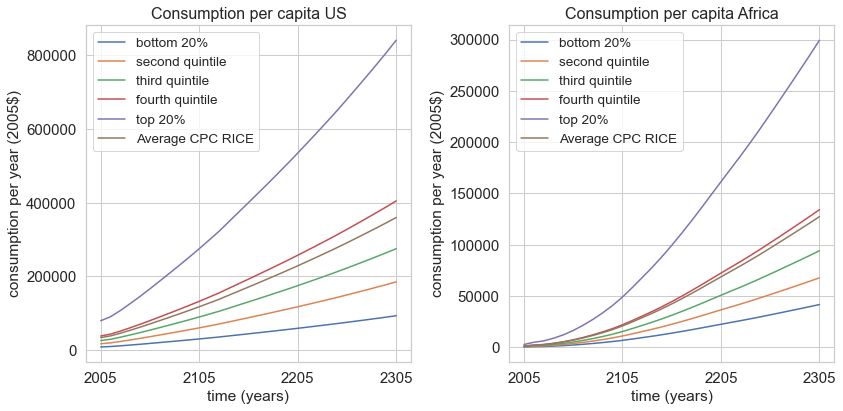

In [22]:
#sns.set(font_scale=1.3)  # crazy big
#sns.set_context(rc={"legend.labelsize":5})   
#sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6),tight_layout=True)
#fig.suptitle("Comparison consumption per capita (CPC) income quintiles Africa & United States", fontsize=15)

for quintile in range(0,6):
    if quintile == 0:
        CPC_quint_us.iloc[:,quintile].plot(ax=axes[0]); 
        axes[0].set_title('Consumption per capita US'), axes[0].legend(),
        axes[0].set(xlabel='time (years)', ylabel='consumption per year (2005$)')
    else:
        CPC_quint_us.iloc[:,quintile].plot(ax=axes[0],secondary_y=False), axes[0].legend()
    

for quintile in range(0,6):
    if quintile == 0:
        CPC_quint_africa.iloc[:,quintile].plot(ax=axes[1]); axes[1].set_title('Consumption per capita Africa'), 
        axes[1].legend(),axes[1].set(xlabel='time (years)', ylabel='consumption per year (2005$)')
    else:
        CPC_quint_africa.iloc[:,quintile].plot(ax=axes[1],secondary_y=False), axes[1].legend()

#axes[0].set(xlim=(2005.0,2305.0))
#axes[1].set(xlim=(2005,2305))

plt.savefig("validation_CPC.png", dpi=200)


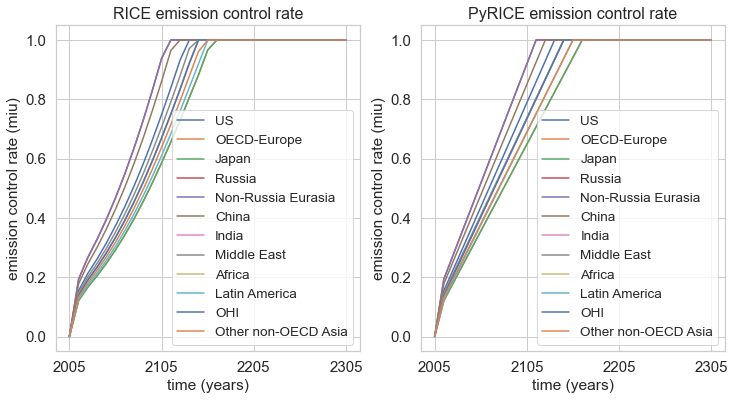

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for region in range(0,12):
    if region == 0:
        miu_opt_series.iloc[:,region].plot(ax=axes[0]); 
        axes[0].set_title('RICE emission control rate'), axes[0].legend(),
        axes[0].set(xlabel='time (years)', ylabel='emission control rate (miu)')
    else:
        miu_opt_series.iloc[:,region].plot(ax=axes[0],secondary_y=False), axes[0].legend()

for region in range(0,12):
    if region == 0:
        output_miu.iloc[:,region].plot(ax=axes[1]); axes[1].set_title('PyRICE emission control rate'), 
        axes[1].legend(),axes[1].set(xlabel='time (years)', ylabel='emission control rate (miu)')
    else:
        output_miu.iloc[:,region].plot(ax=axes[1],secondary_y=False), axes[1].legend()
        
plt.savefig("validation_emission_control_rate.png", dpi=200)




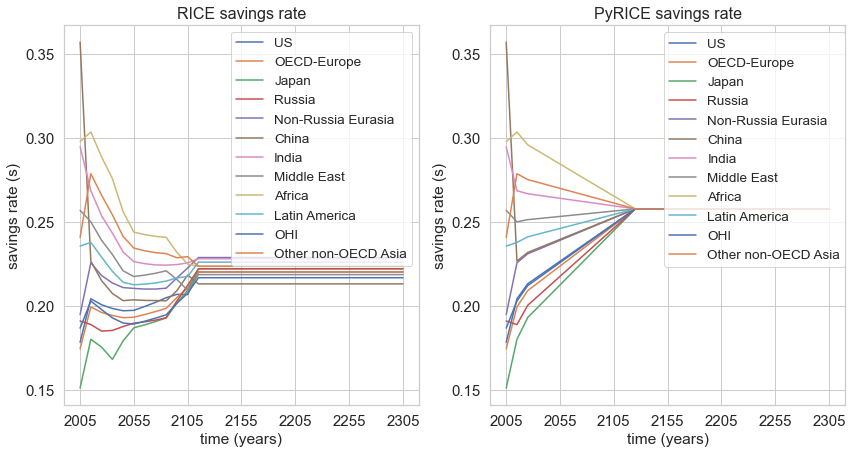

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

for region in range(0,12):
    if region == 0:
        sr_opt_series.iloc[:,region].plot(ax=axes[0]); 
        axes[0].set_title('RICE savings rate'), axes[0].legend(),
        axes[0].set(xlabel='time (years)', ylabel='savings rate (s)')
    else:
        sr_opt_series.iloc[:,region].plot(ax=axes[0],secondary_y=False), axes[0].legend()

for region in range(0,12):
    if region == 0:
        output_sr.iloc[:,region].plot(ax=axes[1]); axes[1].set_title('PyRICE savings rate'), 
        axes[1].legend(),axes[1].set(xlabel='time (years)', ylabel='savings rate (s)')
    else:
        output_sr.iloc[:,region].plot(ax=axes[1],secondary_y=False), axes[1].legend()
plt.legend(bbox_to_anchor=(0.49, 0.98), loc=2, borderaxespad=0.)


plt.savefig("validation_savings_rate.png", dpi=200)